# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

EPS = 1.e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us 
# an evaluation of given parameter values.
class Repressilator(object):
  def __init__(self, y_real, params):
    super().__init__()
    self.y_real = y_real.copy()
    self.params = params.copy()

  # The definition of the gene repressilator model as a system of ODEs.
  def repressilator_model(self, t, y):
    m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

    alpha0 = self.params['alpha0']
    n = self.params['n']
    beta = self.params['beta']
    alpha = self.params['alpha']

    dm1_dt = -m1 + alpha / (1. + p3**n) + alpha0
    dp1_dt = -beta * (p1 - m1)
    dm2_dt = -m2 + alpha / (1. + p1**n) + alpha0
    dp2_dt = -beta * (p2 - m2)
    dm3_dt = -m3 + alpha / (1. + p2**n) + alpha0
    dp3_dt = -beta * (p3 - m3)

    return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

  # A numerial solver for the model (here we use Runge-Kutta 4.5)
  def solve_repressilator(self):
    # we need to use lambda function if we want to pass some parameters
    solution = solve_ivp(lambda t, y: self.repressilator_model(t, y), 
                         t_span=(self.params['t0'], self.params['t1']),
                         y0=self.params['y0'],
                         method='RK45', t_eval=self.params['t_points'])
    y_points = np.asarray(solution.y)
    return self.params['t_points'], y_points

  # An auxiliary function: setting parameters.
  def set_params(self, x):
    self.params['alpha0'] = x[0]
    self.params['n'] = x[1]
    self.params['beta'] = x[2]
    self.params['alpha'] = x[3]

  # Calculating the objective function.
  # Here, we use the Euclidean distance between the real data and the synthetic data.
  @staticmethod
  def loss(y_real, y_model):
    # we assume only m's are observed!
    y_r = y_real[0:3]
    y_m = y_model[0:3]
    if y_r.shape[1] == y_m.shape[1]:
      return np.mean(np.sqrt(np.sum((y_r - y_m)**2, 0)))
    else:
      return np.infty

  def objective(self, x):
    if len(x.shape) > 1:
      objective_values = []
      for i in range(x.shape[0]):
        xi = x[i]
        self.set_params(xi)

        _, y_model = self.solve_repressilator()
        objective_values.append(self.loss(self.y_real, y_model))

      objective_values = np.asarray(objective_values)
    else:
      self.set_params(x)

      _, y_model = self.solve_repressilator()
      objective_values = self.loss(self.y_real, y_model)

    return objective_values

In [3]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem 
# more realistic, we add a small Gaussian noise.
params = {}
params['alpha0'] = 1.1
params['n'] = 2.9
params['beta'] = 5.5
params['alpha'] = 500
params['t0'] = 0.
params['t1'] = 60.5
params['t_points'] = np.asarray([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  
                                 4. ,  4.5,  5. , 5.5,  6. ,  6.5,  7. ,  7.5,  
                                 8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 
                                 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 
                                 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 
                                 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 
                                 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 
                                 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 
                                 32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 
                                 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. , 39.5, 
                                 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 
                                 44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 
                                 48. , 48.5, 49. , 49.5, 50. , 50.5, 51. , 51.5, 
                                 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. , 55.5, 
                                 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5])
params['x0'] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145 ]])
params['y0'] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del(r) # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5. # add noise!

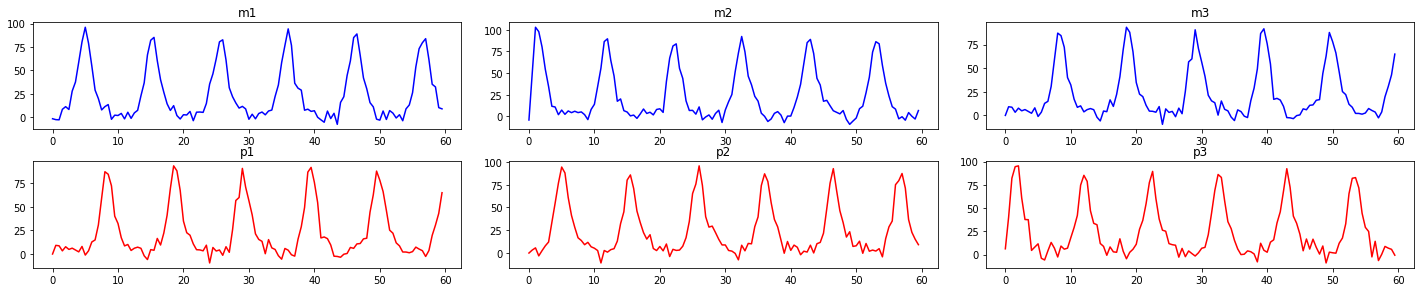

In [4]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params['t_points']

fig_data, axs = plt.subplots(2,3,figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
  for j in range(3):
    if i == 0:
      title = 'm'
      color = 'b'
    else:
      title = 'p'
      color = 'r'
    
    axs[i,j].plot(t, y_real[2*i+j], color)
    axs[i,j].set_title(title + str(j+1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
PLEASE FILL IN

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
PLEASE FILL IN

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
PLEASE FILL IN

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
PLEASE FILL IN

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**
1. (Init) Initialize a population of solutions, Pt :+ P0, and evaluate.
2. repeat until STOP:
    
    i. (Generate) Generate new solutions, St+1, by applying mutation and recombination to Pt.
    
    ii. (Evaluate) Evaluate new solutions. #fitness function
    
    iii. (Select) Select Pt+1 from Pt and S t+1

In [ ]:
### =========
# GRADING:
# 0 
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
#=========
# Implement the Metropolis Hasting (MH) algorithm. 
# It is equivalent to implementing the step function.
class EA(object):
  def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None):
      self.repressilator = repressilator
      self.pop_size = pop_size
      self.bounds_min = bounds_min
      self.bounds_max = bounds_max
      #-------
      # PLEASE FILL IN
      # all necessary hyperparameters come here
      #------- 
  
  #-------
  # PLEASE FILL IN
  # all necessary operations (e.g., mutation, selection) must come here.
  #-------

  # Evaluation step: DO NOT REMOVE!
  def evaluate(self, x):
    return self.repressilator.objective(x)
  
  def step(self, x_old, f_old):
    #-------
    # PLEASE FILL IN
    # NOTE: This function must return x, f
    # where x - population
    #       f - fitness values of the population
    #-------
    
    return x, f

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here. **pogrubiony tekst**

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [ ]:
# PLEASE DO NOT REMOVE!
num_generations = 50 # if necessary, please increase the number of generations
pop_size = 100
bounds_min = [-2., 0., -5., 0.]
bounds_max = [10., 10., 20., 2500.]
#-------
# PLEASE FILL IN!
# Your hyperparams go here.
# PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# DO NOT ITERATE OVER THEM!
#-------

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

#-------
# PLEASE FILL IN!
# Your object goes here:
# ea = EA(...)
#-------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
  if i % int(num_generations * 0.1) == 0:
    print('Generation: {}, best fitness: {:.2f}'.format(i, f.min()))
  x, f = ea.step(x, f)
  populations.append(x)
  if f.min() < f_best[-1]:
    f_best.append(f.min())
  else:
    f_best.append(f_best[-1])
print('FINISHED!')

In [ ]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(x[f.argmin()],)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2,3,figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
  for j in range(3):
    if i == 0:
      title = 'm'
      color = 'b'
      color_m = 'm'
    else:
      title = 'p'
      color = 'r'
      color_m = 'c'
    
    axs[i,j].plot(t, y_real[2*i+j], color, label='Data')
    axs[i,j].plot(t, y_best[2*i+j], color_m, label='EA')
    axs[i,j].set_title(title + str(j+1))
    axs[i,j].legend()

In [ ]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations//4, num_generations//2, num_generations]
fig_ea_pops, axs = plt.subplots(1,4,figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
  pop_i = populations[gens[i]]
  axs[0].scatter(pop_i[:,0], pop_i[:,1], label=str(gens[i]))
  axs[1].scatter(pop_i[:,0], pop_i[:,2], label=str(gens[i]))
  axs[2].scatter(pop_i[:,2], pop_i[:,3], label=str(gens[i]))
  axs[3].scatter(pop_i[:,1], pop_i[:,2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r'$\alpha_0$ vs. $n$')
axs[1].set_title(r'$\alpha_0$ vs. $\beta$')
axs[2].set_title(r'$\beta$ vs. $\alpha$')
axs[3].set_title(r'$n$ vs. $\alpha$')

In [ ]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title('The convergence')
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: PLEASE FILL IN

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: PLEASE FILL IN

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: PLEASE FILL IN

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: PLEASE FILL IN

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: PLEASE FILL IN

**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: PLEASE FILL IN